In [1]:
import matplotlib.pyplot as plt
import numpy as np

from src.load_ecg_data import load_ecg_data
from src.find_ecg_peaks import find_ecg_peaks
from src.annotations import get_heart_sound_timings_by_intervals, save_annotations_to_file
from src.intervals import find_good_intervals
from src.load_audio_data import load_audio_data
from src.align_audio import align_audio

from example_dataset.alignments import get_alignment_offset

In [2]:
activity = 'Cooldown'
subject = 14

annotations_base_filename = f'annotation_{activity}_{subject}'

ecg_folder_path = './example_dataset/ECG_Data/'
ecg_filepath_template = '{}_{}.csv'
ecg_csv_filepath = ecg_folder_path + ecg_filepath_template.format(activity, subject)

ecg, ecg_sample_rate = load_ecg_data(ecg_csv_filepath)
alignment_offset = get_alignment_offset(subject)

In [3]:
audio_folder_path = './example_dataset/Mic_Data/'
audio_filepath_template = '{}_{}.wav'
audio_filepath = audio_folder_path + audio_filepath_template.format(activity, subject)

audio, audio_timestamps, audio_sample_rate = load_audio_data(audio_filepath)

In [4]:
ecg_peaks = find_ecg_peaks(ecg, ecg_sample_rate)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


In [5]:
heart_sound_annotations_by_intervals = get_heart_sound_timings_by_intervals(ecg_peaks, audio_timing_offset = alignment_offset)

In [6]:
annotations_folder_path = './annotations/'
save_annotations_to_file(annotations_folder_path, annotations_base_filename, heart_sound_annotations_by_intervals, include_timestamp=True)

In [7]:
audio_timestamps = np.array([i / audio_sample_rate for i in range(len(audio))])
aligned_audio_timestamps = align_audio(audio_timestamps, alignment_offset)

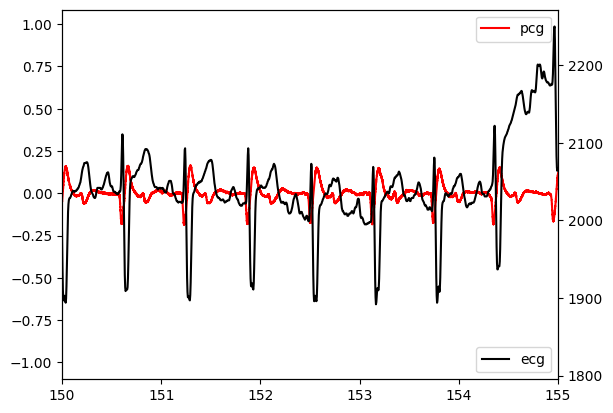

In [8]:
# check ecg and audio are aligned
fig, ax1 = plt.subplots()
ax1.set_xlim(150, 155)
ax2 = ax1.twinx()

ecg_timestamps = np.array([i / ecg_sample_rate for i in range(len(ecg))])

ax1.plot(aligned_audio_timestamps, audio, color='red', label='pcg')
ax2.plot(ecg_timestamps, ecg, color='black', label='ecg')

ax1.legend()
ax2.legend(loc='lower right')

In [9]:
intervals = find_good_intervals(ecg_peaks)

In [10]:
def flatten_list_of_lists(l):
    return [item for sublist in l for item in sublist]

def flat_map(f, items):
    return flatten_list_of_lists(map(f, items))

s1s = flat_map(lambda interval: interval['s1Timings'], heart_sound_annotations_by_intervals)
s2s = flat_map(lambda interval: interval['s2Timings'], heart_sound_annotations_by_intervals)

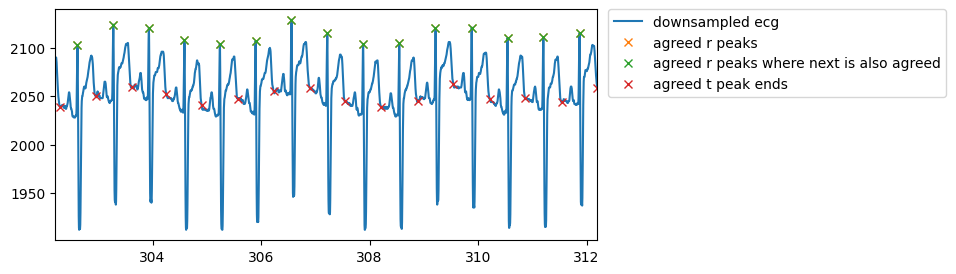

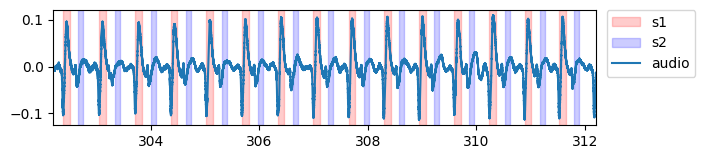

In [11]:
def filter_time_to_within_period (times, period_start, period_end):
    mask = (times >= period_start) & (times <= period_end)
    return times[mask]

def filter_times_and_signal_to_within_period (times, signal, period_start, period_end):
    mask = (times >= period_start) & (times <= period_end)
    return times[mask], signal[mask]

def filter_sounds_to_within_period (sounds, period_start, period_end):
    return [
        (start, end)
        for start, end in sounds
        if start >= period_start and end <= period_end
    ]

time_downsampled = np.arange(len(ecg_peaks.downsampled_signal)) / ecg_peaks.downsampled_sample_rate

interval = intervals[np.argmax([i['intervalEnd'] - i['intervalStart'] for i in intervals])]
interval_start_time = interval['intervalStart']
interval_end_time = interval['intervalEnd']

duration = 10
middle = (interval_start_time + interval_end_time) / 2
start_time = middle - duration / 2
end_time = middle + duration / 2

r_peaks = filter_time_to_within_period(ecg_peaks.r_peaks, start_time, end_time)
rpeaks_where_next_is_also_agreed = filter_time_to_within_period(ecg_peaks.rpeaks_where_next_is_also_agreed, start_time, end_time)
t_peak_ends = filter_time_to_within_period(ecg_peaks.t_peak_ends, start_time, end_time)

fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(*filter_times_and_signal_to_within_period(time_downsampled, ecg_peaks.downsampled_signal, start_time, end_time), label='downsampled ecg')

ax.plot(r_peaks, [ecg_peaks.downsampled_signal[np.argmin(np.abs(time_downsampled - t))] for t in r_peaks], 'x', label='agreed r peaks')
ax.plot(rpeaks_where_next_is_also_agreed, [ecg_peaks.downsampled_signal[np.argmin(np.abs(time_downsampled - t))] for t in rpeaks_where_next_is_also_agreed], 'x', label='agreed r peaks where next is also agreed')
ax.plot(t_peak_ends, [ecg_peaks.downsampled_signal[np.argmin(np.abs(time_downsampled - t))] for t in t_peak_ends], 'x', label='agreed t peak ends')

ax.set_xlim(start_time, end_time)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig, ax = plt.subplots(figsize=(7, 1.5))

for i, (t1, t2) in enumerate(filter_sounds_to_within_period(s1s, start_time, end_time)):
    ax.axvspan(t1, t2, alpha=0.2, color='red', label='s1' if i == 0 else None)

for i, (t1, t2) in enumerate(filter_sounds_to_within_period(s2s, start_time, end_time)):
    ax.axvspan(t1, t2, alpha=0.2, color='blue', label='s2' if i == 0 else None)

ax.plot(*filter_times_and_signal_to_within_period(audio_timestamps, audio, start_time, end_time), label='audio')

ax.set_xlim(start_time, end_time)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)